# Installing Packages 

In [32]:
!pip install scrapy
!pip install dfply

# Importing Packages 

In [83]:
# importing packages for scraping 
import scrapy
from scrapy.crawler import CrawlerProcess

# importing pandas for data manipulation and transformation
import pandas as pd 
import re

# importing packages for visualization 
import matplotlib.pyplot as plt
import seaborn as sns 
from plotnine import *
from dfply import *

# importing packages for scientific computations
import numpy as np
from math import sqrt
from datetime import date

# importing packages for model building
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm 
from scipy import stats

# Data Scraping and Cleaning 

In [ ]:
# Scraping data by using a dedicated DeviceModelsScraper class, which is derived 
# from scrapy.Spider parent. The class is constructed by the flow of the website navigation 
# to be able to scrape the specifications regarding each device. 
# Then the crawler process is used to run the spider.
class   (scrapy.Spider):
    name = 'DeviceModelsBot'
    allowed_domains = ['www.gsmarena.com','m.gsmarena.com']
    start_urls = ['https://www.gsmarena.com/']

    def parse(self, response):
        brands_list_page = response.css('div[id="instores-container"] ~ h2.section > a')
        yield from response.follow_all(brands_list_page, self.parse_brands_list)

    def parse_brands_list(self, response):
        brand_pages = response.css('div.general-menu a')
        yield from response.follow_all(brand_pages, self.parse_brand_page)

    def parse_brand_page(self, response):
        device_pages = response.css('div.general-menu a')
        yield from response.follow_all(device_pages, self.parse_device)

        pagination_links = response.css('a.left ~ a')
        yield from response.follow_all(pagination_links, self.parse_brand_page)

    def parse_device(self, response):
        brand = response.css('h1.nobor::text').re(r'^\S*')
        model = response.css('h1.nobor::text').re(r'\s(.*)')
        release_year = response.css('td[data-spec="year"]::text').re_first(r'\d{4}')
        release_month = response.css('td[data-spec="year"]::text').re_first(r'\d{4}.{0,2}([a-zA-Z]{3,})')
        website_views = response.css("span[id='popularity-vote']::text").re(r'\d+,*\d+')
        website_likes = response.css("span[id='fan-vote'] strong::text").extract()
        display_size = response.css('span[data-spec="displaysize-hl"]::text').re_first(r'\d{1,2}.\d*')
        display_pixel_width = response.css('td[data-spec="displayresolution"]::text').re(r'(\d+)\s?[x]')
        display_pixel_height = response.css('td[data-spec="displayresolution"]::text').re(r'[x]\s?(\d+)')
        camera_megapixels = response.css('td[data-spec="cam1modules"]::text').re(r'^\d+')
        video_pixels = response.css('span[data-spec="videopixels-hl"]::text').extract()
        memory_gb_size = response.css('td[data-spec="internalmemory"]::text').re(r'^\d+[MBGK]{2}')
        ram_gb_size = response.css('td[data-spec="internalmemory"]::text').re_first(r'(\d+[MBGK]{2})\s*RAM')
        battery_mah_size = response.css('span[data-spec="batsize-hl"]::text').extract()
        network_types = response.css('td[data-spec="nettech"]::text').extract()
        dimension_height = response.css('td[data-spec="dimensions"]::text').re(r'^\S*')
        dimension_width = response.css('td[data-spec="dimensions"]::text').re(r'x\s(\d+.?\d)\sx')
        dimension_thickness = response.css('td[data-spec="dimensions"]::text').re(r'x\s(\d+.?\d)\sm')
        os = response.css('td[data-spec="os"]::text').extract()
        chipset = response.css('td[data-spec="chipset"]::text').extract()
        cpu = response.css('td[data-spec="cpu"]::text').extract()
        gpu = response.css('td[data-spec="gpu"]::text').extract()
        memory_slot = response.css('td[data-spec="memoryslot"]::text').re(r'^\w+')
        loudspeaker = response.xpath(
            "//table[9]//tbody[1]//tr[2]//td[2]/text()").re(r'^\w+')
        audiojack = response.xpath("//a[text()[contains(.,'3.5mm jack')]]/parent::td/following-sibling::td/text()").re(
            r'^\w+')
        wifi = response.css('td[data-spec="wlan"]::text').re(r'^\w+-?\w+')
        bluetooth = response.css('td[data-spec="bluetooth"]::text').re(r'^\S{0,3}')
        gps = response.css('td[data-spec="gps"]::text').re(r'^([\w\-]+)')
        radio = response.css('td[data-spec="radio"]::text').re(r'^\w+')
        price = response.css('td[data-spec="price"]::text').re_first(r'\d+\.?')

        yield {
            'brand': brand,
            'model': model,
            'release_year': release_year,
            'release_month': release_month,
            'website_views': website_views,
            'website_likes': website_likes,
            'display_size': display_size,
            'display_pixel_width': display_pixel_width,
            'display_pixel_height': display_pixel_height,
            'camera_megapixels': camera_megapixels,
            'video_pixels': video_pixels,
            'memory_gb_size': memory_gb_size,
            'ram_gb_size': ram_gb_size,
            'battery_mah_size': battery_mah_size,
            'network_types': network_types,
            'dimension_height': dimension_height,
            'dimension_width': dimension_width,
            'dimension_thickness': dimension_thickness,
            'os': os,
            'chipset': chipset,
            'cpu': cpu,
            'gpu': gpu,
            'memory_slot': memory_slot,
            'loudspeaker': loudspeaker,
            'audiojack': audiojack,
            'wifi': wifi,
            'bluetooth': bluetooth,
            'gps': gps,
            'radio': radio,
            'price': price
        }


process = CrawlerProcess(settings={
    "FEEDS": {
        "devices.csv": {"format": "csv"},
    },
    "USER_AGENT": 'DeviceModelsScraper',
    "ROBOTSTXT_OBEY": True,
    "CONCURRENT_REQUESTS": 8,
    "DOWNLOAD_DELAY": 0.5,
    "RANDOMIZE_DOWNLOAD_DELAY": True
})
scraper = DeviceModelsScraper()
process.crawl(DeviceModelsScraper)
process.start()

In [34]:
# Reading the csv file for further cleaning and analysis. 
FILE_NAME = "devices.csv"
df = pd.read_csv(FILE_NAME)
devices = df.copy()

In [35]:
# Cleaning data and dividing some variables into categories.
df['brand'] = np.where((df.brand == 'Apple') | (df.brand == 'Samsung') | (df.brand == 'Huawei'), df.brand, 'Other')
df['website_views'] = df.website_views.str.replace(",","")
df['display_pixel_width'] = df.display_pixel_width.str.extract('(\d+)', expand=True)
df['display_pixel_height']= df.display_pixel_width.str.extract('(\d+)$', expand=True)
df['dimension_height']= df.dimension_height.str.extract('^(\d+)', expand=True)
df['dimension_width']= df.dimension_width.str.extract('(\d+.?\d*)$', expand=True)
df['dimension_thickness']= df.dimension_width.str.extract('(\d+.?\d*)', expand=True)
df['bluetooth'] = df.bluetooth.str.extract('^(\d+)', expand=True)
df['cpu_brand'] = df.chipset.str.extract('^([A-Za-z]+)', expand=True)
df['cpu_nm'] = df.chipset.str.extract('(\d+)\s?nm', expand=True)
df['cpu_type'] = df.cpu.str.extract('^([A-Za-z-]+)', expand=True)
df['cpu_type'] = np.where(df.cpu_type == 'Quadcore', 'Quad-core', df.cpu_type)
df.cpu_type[df.cpu_type == 'Octa-core'] = 8
df.cpu_type[df.cpu_type == 'Quad-core'] = 4
df.cpu_type[df.cpu_type == 'Dual-core'] = 2
df.cpu_type[df.cpu_type == 'Hexa-core'] = 6
df.cpu_type[df.cpu_type == 'Deca-core'] = 10
df.cpu_type[df.cpu_type == 'Triple-core'] = 3
df['cpu_mhz'] = np.where(df.cpu.str.contains(r'\d+\.*\d*\s*[GgHhZz]'), pd.to_numeric(df.cpu.str.extract(r'(\d+\.*\d*)\s*[GgHhZz]')[0])*1000,  pd.to_numeric(df.cpu.str.extract(r'(\d+\.*\d*)\s*[MhHhZz]')[0]))
df.drop('chipset', axis=1, inplace=True)
df.drop('cpu', axis=1, inplace=True)
df['gpu'] = df.gpu.replace(['3D Graphics HW Accelerator'],'Nokia 3D Graphics HW Accelerator')
df['gpu_brand'] = df.gpu.str.extract('^([A-Za-z]+)', expand=True)
df.drop('gpu', axis=1, inplace=True)
df['ram'] = df['ram_gb_size']
df['ram_mb_size'] = np.where(df.ram.str.contains(r'GB$'), pd.to_numeric(df.ram.str.extract(r'^([0-9]+)')[0])*1024,  pd.to_numeric(df.ram.str.extract(r'^([0-9]+)')[0]))
df.drop('ram_gb_size', axis=1, inplace=True)
df.drop('ram', axis=1, inplace=True)
df['memory'] = df.memory_gb_size
df['memory_mb_size'] = np.where(df.memory.str.contains(r'GB$'), pd.to_numeric(df.memory.str.extract(r'^([0-9]+)')[0])*1024,  pd.to_numeric(df.memory.str.extract(r'^([0-9]+)')[0]))
df.drop('memory_gb_size', axis=1, inplace=True)
df.drop('memory', axis=1, inplace=True)
df['release_month'] = np.where(df.release_month.str.contains(r'^Jan|Feb|Mar'), 'Q1', df.release_month)
df['release_month'] = np.where(df.release_month.str.contains(r'^Apr|May|Jun'), 'Q2', df.release_month)
df['release_month'] = np.where(df.release_month.str.contains(r'^Jul|Aug|Sep'), 'Q3', df.release_month)
df['release_month'] = np.where(df.release_month.str.contains(r'^Oct|Nov|Dec'), 'Q4', df.release_month)
df['release_month'] = np.where(df.release_month.str.contains(r'Q1|Q2|Q3|Q4$'), df.release_month, np.nan)
df['video_pixels'] = np.where(df.video_pixels.str.contains(r'\d+p$'), pd.to_numeric(df.video_pixels.str.extract(r'(\d+)p$')[0]), np.nan)
df['os_type'] = df.os.str.extract('(^[A-Za-z0-9]+)', expand=True)
df['os_type'] = np.where((df.os_type == 'Android') | (df.os_type == 'Microsoft') | (df.os_type == 'iOS'), df.os_type, 'Other')
df['os_version'] = df.os.str.extract('([0-9.]+)', expand=True)
df.drop('os', axis=1, inplace=True)
df.drop('wifi',axis = 1, inplace=True)
df['price']=df['price'].replace(0, np.nan)
df.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/i

In [36]:
# Changing the types of variables. 
df['brand']= df['brand'].astype("string")
df['model']= df['model'].astype("string")
df['release_year']= df['release_year'].astype(int)
df['release_month']= df['release_month'].astype("string")
df['website_views']= df['website_views'].astype(int)
df['display_pixel_width']= df['display_pixel_width'].astype(int)
df['display_pixel_height']= df['display_pixel_height'].astype(int)
df['video_pixels']= df['video_pixels'].astype(int)
df['battery_mah_size']= df['battery_mah_size'].astype(int)
df['network_types']= df['network_types'].astype("string")
df['dimension_height']= df['dimension_height'].astype(float)
df['dimension_width']= df['dimension_width'].astype(float)
df['dimension_thickness']= df['dimension_thickness'].astype(float)
df['memory_slot']= df['memory_slot'].astype("string")
df['loudspeaker']= df['loudspeaker'].astype("string")
df['audiojack']= df['audiojack'].astype("string")
df['loudspeaker']= df['loudspeaker'].astype("string")
df['bluetooth']= df['bluetooth'].astype(float)
df['gps']= df['gps'].astype("string")
df['radio']= df['radio'].astype("string")
df['cpu_brand']= df['cpu_brand'].astype("string")
df['cpu_nm']= df['cpu_nm'].astype(int)
df['cpu_type']= df['cpu_type'].astype("int")
df['cpu_mhz']= df['cpu_mhz'].astype(int)     
df['gpu_brand']= df['gpu_brand'].astype("string")       
df['ram_mb_size']= df['ram_mb_size'].astype(int)     
df['memory_mb_size']= df['memory_mb_size'].astype(int)    
df['os_type']= df['os_type'].astype("string")
df['os_version']= df['os_version'].astype("string")  
df['price']=df['price'].astype(int)

# Descriptive Analytics

In [ ]:
# Data overview. 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1955 entries, 3 to 10016
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   brand                 1955 non-null   string 
 1   model                 1955 non-null   string 
 2   release_year          1955 non-null   int64  
 3   release_month         1955 non-null   string 
 4   website_views         1955 non-null   int64  
 5   website_likes         1955 non-null   int64  
 6   display_size          1955 non-null   float64
 7   display_pixel_width   1955 non-null   int64  
 8   display_pixel_height  1955 non-null   int64  
 9   camera_megapixels     1955 non-null   float64
 10  video_pixels          1955 non-null   int64  
 11  battery_mah_size      1955 non-null   int64  
 12  network_types         1955 non-null   string 
 13  dimension_height      1955 non-null   float64
 14  dimension_width       1955 non-null   float64
 15  dimension_thickness 

In [ ]:
# First 5 rows of the DataFrame. 
df.head()

,brand,model,release_year,release_month,website_views,website_likes,display_size,display_pixel_width,display_pixel_height,camera_megapixels,video_pixels,battery_mah_size,network_types,dimension_height,dimension_width,dimension_thickness,memory_slot,loudspeaker,audiojack,bluetooth,gps,radio,price,cpu_brand,cpu_nm,cpu_type,cpu_mhz,gpu_brand,ram_mb_size,memory_mb_size,os_type,os_version
3,Other,A7,2017,Q1,98222,1,5.00,720,720,5.0,1080,2800,GSM / HSPA,143.0,71.0,71.0,microSDHC,Yes,Yes,4.0,Yes,No,60,Mediatek,28,4,1300,Mali,1024,8192,Android,7.0
4,Other,Axon 10 Pro 5G,2019,Q1,465083,98,6.47,1080,1080,48.0,2160,4000,GSM / CDMA / HSPA / LTE / 5G,159.0,73.4,73.4,microSDXC,Yes,No,5.0,Yes,No,900,Qualcomm,7,8,2840,Adreno,6144,131072,Android,9.0
6,Other,C6,2018,Q2,65504,0,5.50,720,720,8.0,1080,2500,GSM / HSPA,152.0,77.6,77.6,microSDXC,Yes,Yes,4.0,Yes,FM,100,Mediatek,28,4,1300,Mali,1024,16384,Android,8.1
7,Other,Studio G4,2018,Q3,47408,0,5.20,720,720,8.0,1080,2000,GSM / HSPA,141.0,73.5,73.5,microSDXC,Yes,Yes,4.0,Yes,FM,80,Mediatek,28,4,1300,Mali,1024,16384,Android,8.1
9,Other,Blade X,2017,Q4,180461,6,5.50,720,720,13.0,1080,3000,GSM / HSPA / LTE,156.0,77.5,77.5,microSDXC,Yes,Yes,4.0,Yes,FM,120,Qualcomm,28,4,1400,Adreno,2048,16384,Android,7.1.1


In [ ]:
# Summary statistics. 
df.describe()

,release_year,website_views,website_likes,display_size,display_pixel_width,display_pixel_height,camera_megapixels,video_pixels,battery_mah_size,dimension_height,dimension_width,dimension_thickness,bluetooth,price,cpu_nm,cpu_type,cpu_mhz,ram_mb_size,memory_mb_size
count,1955.000000,1.955000e+03,1955.00000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000
mean,2016.178005,3.092754e+06,136.73913,5.680890,913.241944,913.241944,13.730435,1262.048082,3278.276215,154.104348,78.759182,78.759182,4.127366,571.124808,22.843478,5.976982,1710.301790,2895.353453,36364.047059
std,2.002564,6.828341e+06,315.16509,1.213192,343.795815,343.795815,10.368071,526.386686,1280.173039,24.427160,21.776104,21.776104,0.440576,1973.678597,7.950464,2.186303,479.811099,1823.798865,41749.086075
min,2011.000000,4.170000e+03,0.00000,2.630000,240.000000,240.000000,0.000000,288.000000,800.000000,96.000000,2.500000,2.500000,2.000000,40.000000,7.000000,2.000000,1000.000000,512.000000,512.000000
25%,2015.000000,2.558975e+05,14.00000,5.000000,720.000000,720.000000,8.000000,1080.000000,2500.000000,143.000000,71.000000,71.000000,4.000000,150.000000,14.000000,4.000000,1300.000000,1024.000000,16384.000000
50%,2016.000000,8.189180e+05,42.00000,5.500000,720.000000,720.000000,13.000000,1080.000000,3000.000000,151.000000,74.000000,74.000000,4.000000,210.000000,28.000000,8.000000,1500.000000,2048.000000,16384.000000
75%,2018.000000,2.750840e+06,124.50000,6.000000,1080.000000,1080.000000,13.000000,1080.000000,4000.000000,157.000000,76.600000,76.600000,4.000000,310.000000,28.000000,8.000000,2100.000000,4096.000000,32768.000000
max,2020.000000,7.487292e+07,4003.00000,12.900000,3840.000000,3840.000000,108.000000,4320.000000,11560.000000,305.000000,220.600000,220.600000,5.000000,29500.000000,45.000000,10.000000,2960.000000,12288.000000,524288.000000


# Data Visualization 

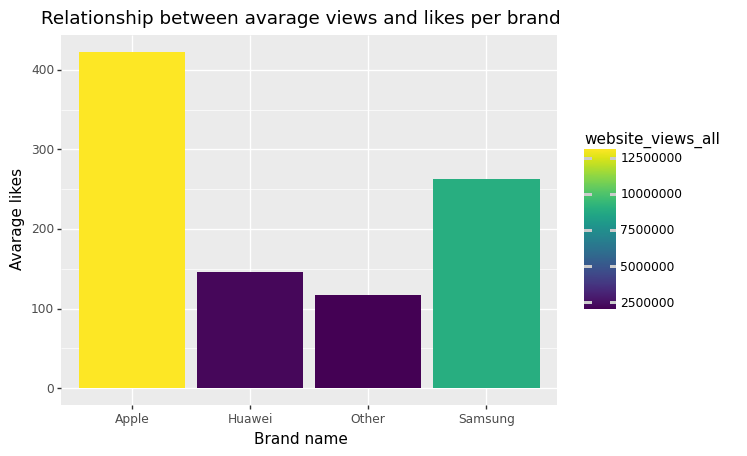

<ggplot: (-9223363246976784745)>

In [10]:
# Plotting the relationship between average views and likes per brand. 
# From this graph we see that Apple and Samsung are the most viewed and likd brands, which is an 
# expected results since they are considered to be the most popular mobile brands.
(df >>  
  group_by('brand') >>
  summarise(website_views_all = X.website_views.mean(),website_likes_all = X.website_likes.mean()) >>
  ggplot(aes(x='brand',y='website_likes_all',fill='website_views_all')) + geom_bar(stat='identity') +
  labs(title = "Relationship between avarage views and likes per brand", x = "Brand name", y = "Avarage likes")
)

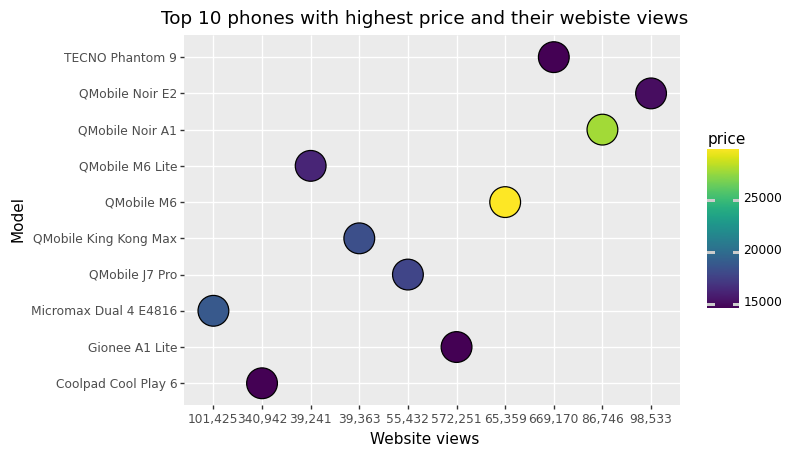

<ggplot: (8755715536911)>

In [ ]:
# We plotted top 10 most expensive phones with their website views and models. However, 
# we cannot observe any linear pattern here as there are phone with high website views and 
# low price, as well as low website view with low price.
(devices >>
  arrange(X.price, ascending=False)>>
  head(10) >>
  mutate(model = X.brand + ' ' + X.model) >>
  ggplot(aes(x = 'website_views', y = 'model', fill='price')) +
  geom_point(size = 12) +
  labs(title = "Top 10 phones with highest price and their webiste views", 
       x = "Website views", y = "Model")
)

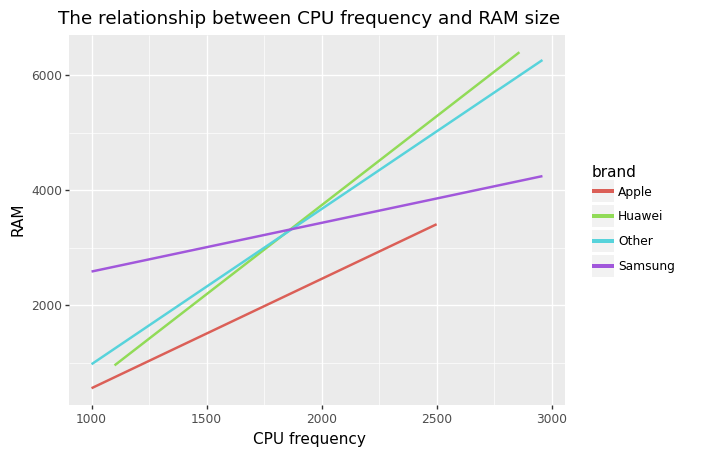

<ggplot: (8755715539036)>

In [ ]:
# Plotting the relationship between CPU frequency and RAM size per brand. 
# From the graph below it can be inferred that in case of Huawei there is a strong positive
# linear relationship between RAM size and CPU frequency. Whereas in case of Samsung this 
# relationship is weaker. However, as expected, in cases of all brand categories the relationship 
# is positive. 
(df >>
  ggplot(aes(x =  'cpu_mhz',  y = 'ram_mb_size', color = 'brand')) +  geom_smooth(se=False) +
  labs(title = 'The relationship between CPU frequency and RAM size', x = 'CPU frequency', y = 'RAM')
)

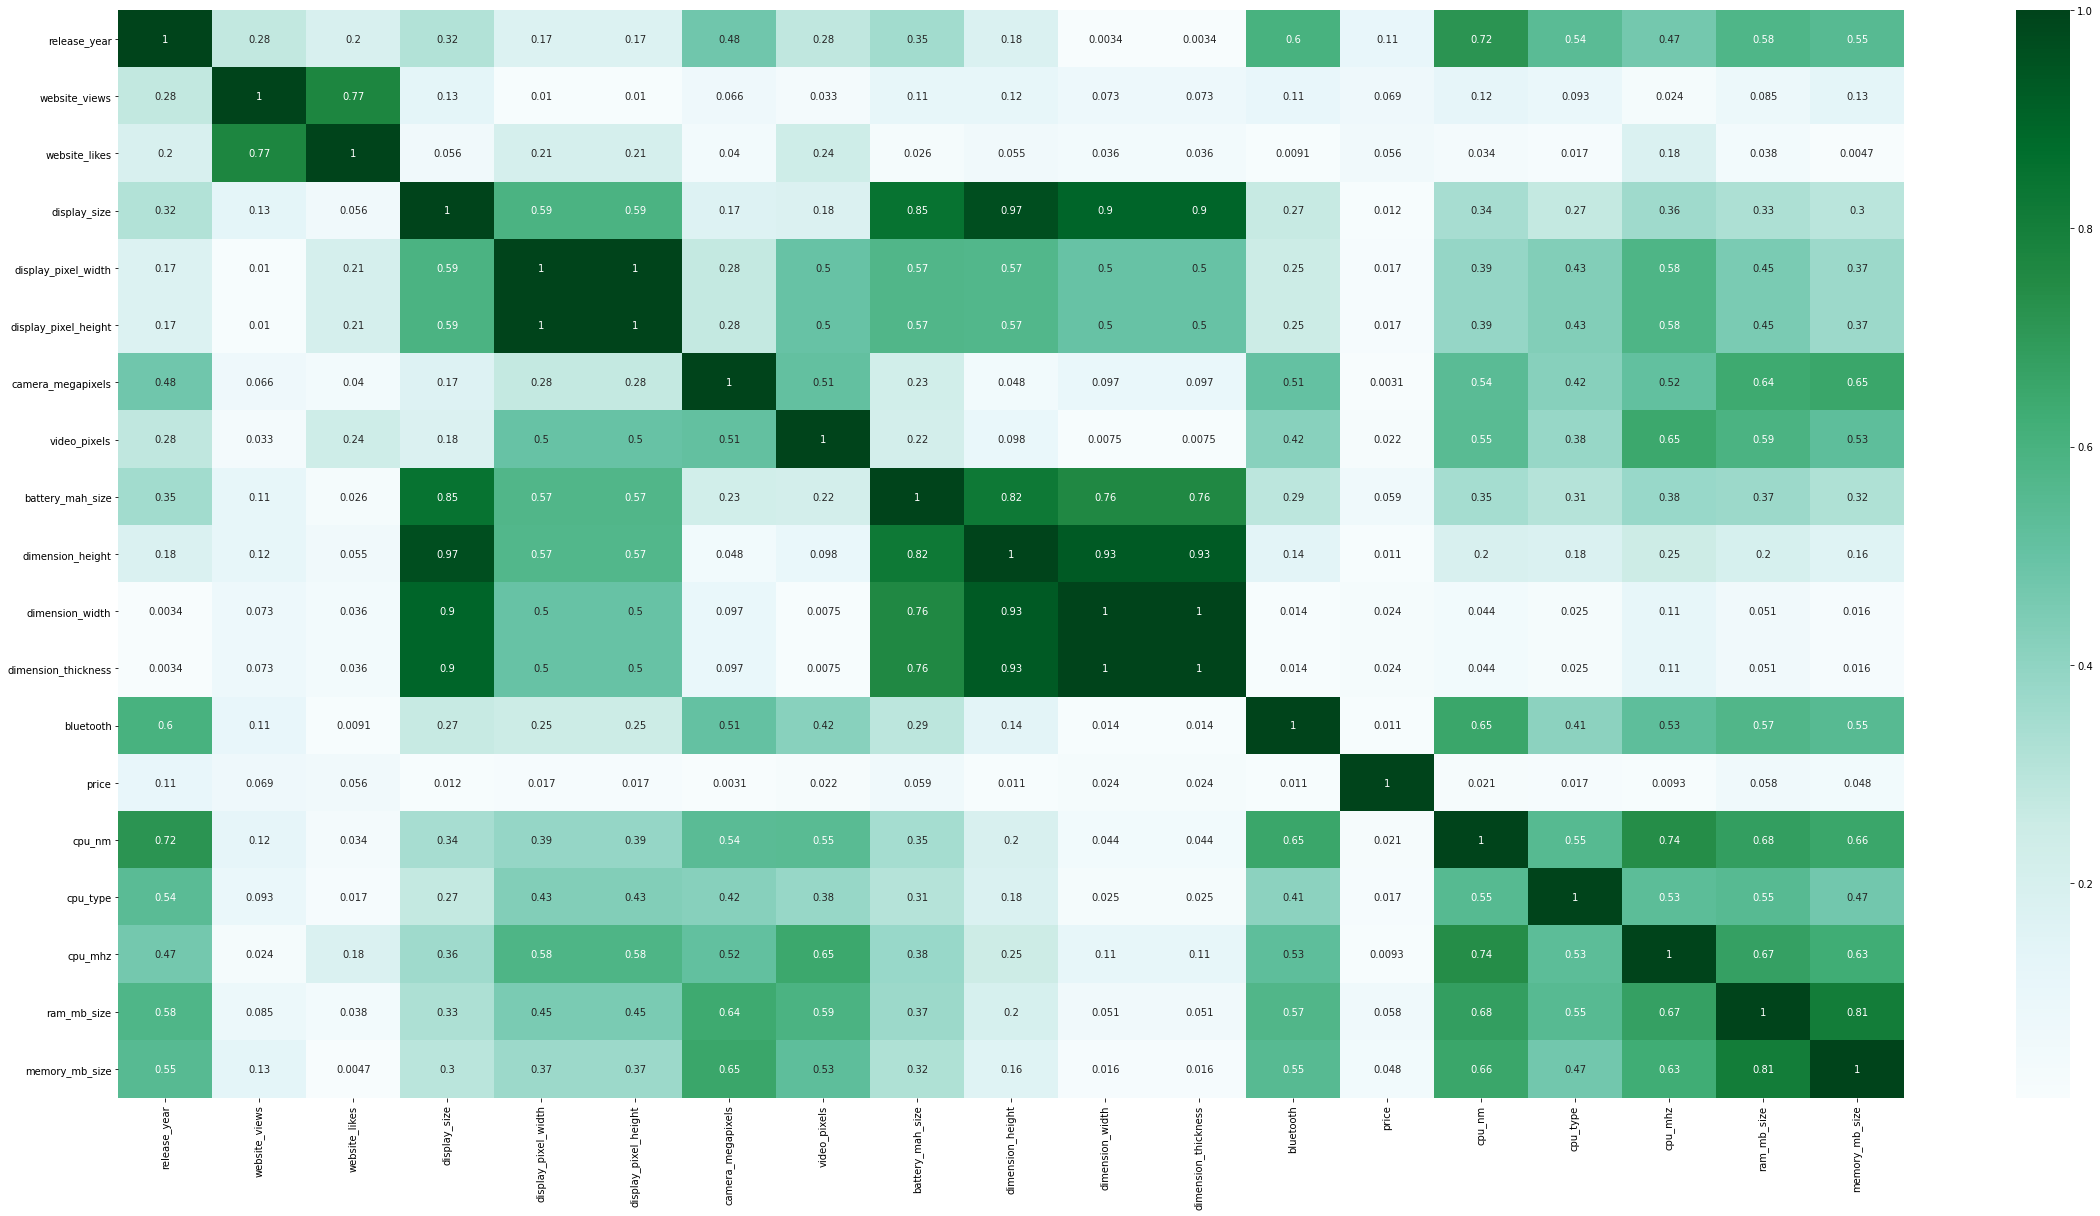

In [ ]:
# Visualising correlations between variables.
plt.figure(figsize=(40,20))
sns.heatmap(df.corr().abs().round(4),annot=True, cmap = "BuGn") 
plt.show()

# Feature Engineering

In [92]:
# Creating a subset of potentially useful variables for the model.  
data = df[["price","brand", "release_year", "display_size", "website_views", "video_pixels","website_likes", "dimension_height", "dimension_width","camera_megapixels", "battery_mah_size", "memory_mb_size", "ram_mb_size","cpu_nm", "os_type","cpu_type","cpu_mhz"]]

In [93]:
# Getting dummy variables of string variables and dropping existing duplicates.
data = pd.get_dummies(data,drop_first=True, prefix=['brand','os_type'], columns=['brand','os_type'])
data.drop_duplicates(inplace = True)

In [94]:
# Checking for duplicates, missing values and single valued columns. 
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


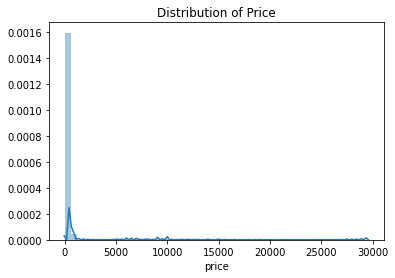

In [95]:
# Checking the distribution of the dependent variable. 
sns.distplot(data.price)
plt.title("Distribution of Price")
plt.show()

In [96]:
# As it was not normal, transforming it into logarithm. 
data.price = np.log(data.price)

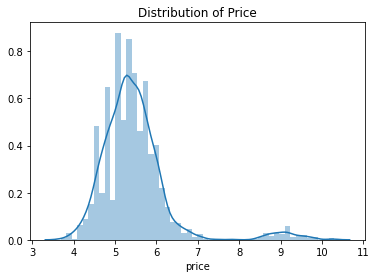

In [97]:
# Checking the distribution after logarithm. It is normal now. 
sns.distplot(data.price)
plt.title("Distribution of Price")
plt.show()

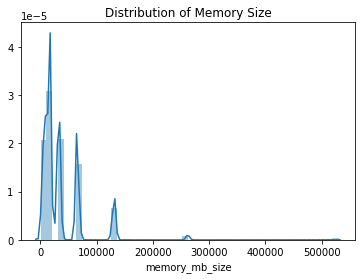

In [98]:
# Checking the distribution of memory_mb_size (one of the independent variables).
sns.distplot(data.memory_mb_size)
plt.title("Distribution of Memory Size")
plt.show()

In [99]:
# As it was not normal, transforming it into logarithm. 
data.memory_mb_size = np.log(data.memory_mb_size)

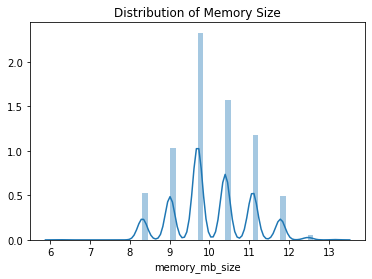

In [100]:
# Checking the distribution after logarithm. It is better now.
sns.distplot(data.memory_mb_size)
plt.title("Distribution of Memory Size")
plt.show()

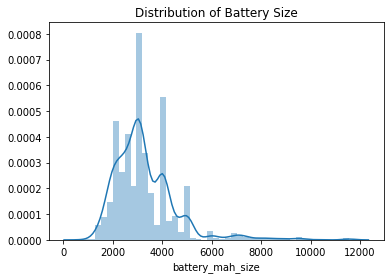

In [101]:
# Checking the distribution of battery_mah_size (one of the independent variables).
sns.distplot(data.battery_mah_size)
plt.title("Distribution of Battery Size")
plt.show()

In [102]:
# As it was not really normal, transforming it into logarithm. 
data.battery_mah_size = np.log(data.battery_mah_size)

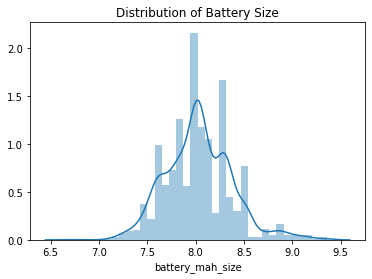

In [103]:
# Checking the distribution after logarithm. It became more normal now.
sns.distplot(data.battery_mah_size)
plt.title("Distribution of Battery Size")
plt.show()

In [104]:
# Creating interaction terms from the existing variables in the dataset. 
data["likes_per_views"]=data["website_likes"]/data["website_views"]
data["display_per_surface"] = data['display_size']*2.54*10/ np.sqrt(np.square(data["dimension_height"])+(np.square(data["dimension_width"])))
data["age"] = date.today().year - data["release_year"]
data["cpu_per_memory"] = data["cpu_nm"]/data["memory_mb_size"]
data["cpu_power"]=data["cpu_mhz"]*data["cpu_type"]

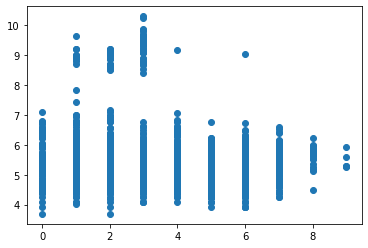

In [105]:
# Plotting the relationship between age and price as it had  
# an unexpected coefficient. As you can see the relationship is not linear. 
plt.scatter(x=data["age"],y=data["price"])
plt.show()

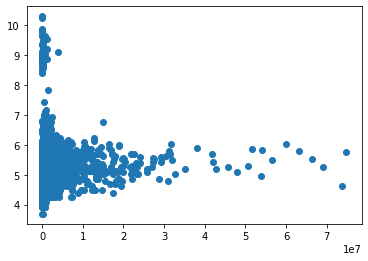

In [106]:
# Plotting the relationship between website views and price as it had 
# an unexpected coefficient. As you can see, generally prices are higher when
# there are less views, which explains negative coefficient. 
plt.scatter(x=data["website_views"],y=data["price"])
plt.show()

# Model Building 

### Linear Regression Hypothesized Model

In [107]:
# Defining dependent and independent variables.
Y=data["price"]
X=data[["brand_Samsung", "brand_Huawei", "brand_Other",  "display_per_surface", "cpu_type", "cpu_per_memory", "age", "camera_megapixels",  "battery_mah_size", "video_pixels", "ram_mb_size"]]

In [108]:
# We have 1955 observations and 11 independent variables.
X.shape

(1955, 11)

In [109]:
# Splitting the data into train and test, taking 25% threshold.
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

In [110]:
# Building and fitting the Linear Regression model.
model_linear = LinearRegression()
model_linear.fit(X0,Y0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [111]:
# Making predictions (y^) for train and test sets. 
Y1_linear = model_linear.predict(X1)
Y0_linear = model_linear.predict(X0)

In [112]:
print(model_linear.coef_)

[-1.87129703e-01 -2.91176399e-01 -1.69189302e-01 -1.82742045e+00
 -1.55076678e-03  4.10694722e-02  2.23049036e-02 -2.15614306e-03
  6.00023583e-01  2.24606298e-04  1.44520507e-04]


In [114]:
# Calculating correlation between predicted and actual values of the dependent
# variable (price).
stats.pearsonr(Y1, Y1_linear) 

(0.4771121123846269, 3.639453316988205e-29)

In [115]:
# Calculating MSE for train and test sets of Linear Regression. 
MSE_train_linear=mean_squared_error(Y0,Y0_linear)
MSE_test_linear=mean_squared_error(Y1,Y1_linear)
print("MSE_train_linear:",MSE_train_linear)
print("MSE_test_linear:",MSE_test_linear)

MSE_train_linear: 0.6864376691913718
MSE_test_linear: 0.46732808368136264


In [116]:
# Calculating MAE for train and test sets of Linear Regression. 
print("MAE_train_linear:",mean_absolute_error(Y0,Y0_linear))
print("MAE_test_linear:", mean_absolute_error(Y1,Y1_linear))

MAE_train_linear: 0.46581757709354255
MAE_test_linear: 0.4110431461158017


In [117]:
# Calculating R^2 for train and test sets of Linear Regression. 
print("R-squared Train:",r2_score(Y0,Y0_linear))
print("R-squared Test:", r2_score(Y1,Y1_linear))

R-squared Train: 0.15530738487889906
R-squared Test: 0.2217535407753387


In [118]:
# Calculating RMSE for train and test sets of Linear Regression. 
RMSE_train_linear=sqrt(MSE_train_linear)
RMSE_test_linear=sqrt(MSE_test_linear)
print("RMSE_train_linear:",RMSE_train_linear)
print("RMSE_test_linear:",RMSE_test_linear)

RMSE_train_linear: 0.8285153403476436
RMSE_test_linear: 0.6836139873359546


In [119]:
# Calculating the mean cross-validation score for the whole data, for 3 folds. 
np.mean(-cross_val_score(estimator=model_linear,X=X, y=Y, scoring="neg_mean_squared_error", cv=3))

0.6570949732058248

### Linear Regression Best Model

In [135]:
# Defining dependent and independent variables.
Y=data["price"]
X=data[["website_likes", "website_views", "age", "battery_mah_size", "memory_mb_size", "ram_mb_size"]]

In [121]:
# We have 1955 observations and 6 independent variables.
X.shape

(1955, 6)

In [136]:
# Splitting the data into train and test, taking 25% threshold.
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

In [123]:
# Building and fitting the Linear Regression model.
model_linear = LinearRegression()
model_linear.fit(X0,Y0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [124]:
# Making predictions (y^) for train and test sets. 
Y1_linear = model_linear.predict(X1)
Y0_linear = model_linear.predict(X0)

In [125]:
print(model_linear.coef_)

[ 1.01381786e-04 -9.14503279e-09  1.02791056e-01  3.90025812e-01
  3.18067529e-01  5.30355392e-05]


In [126]:
# Calculating correlation between predicted and actual values of the dependent
# variable (price).
stats.pearsonr(Y1, Y1_linear) 

(0.530965244192938, 6.428874396936985e-37)

In [127]:
# Calculating MSE for train and test sets of Linear Regression. 
MSE_train_linear=mean_squared_error(Y0,Y0_linear)
MSE_test_linear=mean_squared_error(Y1,Y1_linear)
print("MSE_train_linear:",MSE_train_linear)
print("MSE_test_linear:",MSE_test_linear)

MSE_train_linear: 0.6754366590601398
MSE_test_linear: 0.434297431963809


In [128]:
# Calculating MAE for train and test sets of Linear Regression. 
print("MAE_train_linear:",mean_absolute_error(Y0,Y0_linear))
print("MAE_test_linear:", mean_absolute_error(Y1,Y1_linear))

MAE_train_linear: 0.44601458613350514
MAE_test_linear: 0.3774821034040717


In [129]:
# Calculating R^2 for train and test sets of Linear Regression. 
print("R-squared Train:",r2_score(Y0,Y0_linear))
print("R-squared Test:", r2_score(Y1,Y1_linear))

R-squared Train: 0.1688446256711631
R-squared Test: 0.276759838583446


In [130]:
# Calculating RMSE for train and test sets of Linear Regression. 
RMSE_train_linear=sqrt(MSE_train_linear)
RMSE_test_linear=sqrt(MSE_test_linear)
print("RMSE_train_linear:",RMSE_train_linear)
print("RMSE_test_linear:",RMSE_test_linear)

RMSE_train_linear: 0.8218495355356356
RMSE_test_linear: 0.6590124672294212


In [131]:
# Calculating the mean cross-validation score for the whole data, for 3 folds. 
np.mean(-cross_val_score(estimator=model_linear,X=X, y=Y, scoring="neg_mean_squared_error", cv=3))

0.6305395839258586

### Linear Regression Best Model Using statsmodels.api Package 

In [137]:
# Fitting the LR Best Model with statsmodels.api package as well
# in order to see the p-values of independent variables. 
X0 = sm.add_constant(X0)
model_linear = sm.OLS(Y0,X0)
results = model_linear.fit()

In [139]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     49.40
Date:                Mon, 03 Aug 2020   Prob (F-statistic):           1.98e-55
Time:                        17:27:15   Log-Likelihood:                -1792.5
No. Observations:                1466   AIC:                             3599.
Df Residuals:                    1459   BIC:                             3636.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.3810      0.666     -2.075      0.038      -2.687      -0.075
website_likes        0.0001      0.000      0.833      0.405      -0.000       0.000
website_views    -9.145e-09    5.8e-09     -1.577      0.115   -2.05e-08    2.23e-09
age                  0.1028      0.015      6.656      0.000       0.072       0.133
battery_mah_size     0.3900      0.079      4.965      0.000       0.236       0.544
memory_mb_size       0.3181      0.047      6.715      0.000       0.225       0.411
ram_mb_size       5.304e-05   2.09e-05      2.538      0.011     1.2e-05     9.4e-05
==============================================================================
Omnibus:                     1080.090   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14118.802
Skew:                           3.455   Prob(JB):                         0.00
Kurtosis:                      16.542   Cond. No.                     2.11e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Decision Tree Regressor

In [ ]:
# Setting Decision Tree parameters for grid.
param_dt={"max_depth":range(1,15),"min_samples_leaf":range(10,125,5)}

In [ ]:
# Cross-validating Gridsearch using Decision Tree parameters. 
gs_dt=GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),param_grid=param_dt,cv=3, scoring="neg_mean_squared_error")
gs_dt.fit(X0,Y0)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(10, 125, 5)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
         

In [ ]:
# Finding best parameters. 
gs_dt.best_params_

{'max_depth': 8, 'min_samples_leaf': 20}

In [ ]:
# Fitting the model with best parameters.
dt_grid=DecisionTreeRegressor(max_depth=8,
                             min_samples_leaf=20, random_state=42).fit(X0,Y0)

In [ ]:
# Getting probabilities. 
Y0_dt_grid = dt_grid.predict(X0)
Y1_dt_grid = dt_grid.predict(X1)

In [ ]:
# Calculating MSE for train and test sets of Decision Tree Regressor. 
MSE_train_dt_grid = mean_squared_error(Y0,Y0_dt_grid)
MSE_test_dt_grid = mean_squared_error(Y1,Y1_dt_grid)
print("MSE_train_dt_grid:",MSE_train_dt_grid)
print("MSE_test_dt_grid:",MSE_test_dt_grid)

MSE_train_dt_grid: 0.5288734685986841
MSE_test_dt_grid: 0.46659481502299577


In [ ]:
# Calculating MAE for train and test sets of Decision Tree Regressor. 
print("MAE_train_dt:",mean_absolute_error(Y0,Y0_dt_grid))
print("MAE_test_dt:", mean_absolute_error(Y1,Y1_dt_grid))

MAE_train_dt: 0.42484541563811945
MAE_test_dt: 0.4271376683965236


In [ ]:
# Calculating RMSE for train and test sets of Decision Tree Regressor. 
RMSE_train_dt_grid = sqrt(MSE_train_dt_grid)
RMSE_test_dt_grid = sqrt(MSE_test_dt_grid)
print("RMSE_train_dt_grid:",RMSE_train_dt_grid)
print("RMSE_test_dt_grid:",RMSE_test_dt_grid)

RMSE_train_dt_grid: 0.7272368724141289
RMSE_test_dt_grid: 0.6830774590213


In [ ]:
# Calculating the mean cross-validation score for the whole data, for 3 folds. 
np.mean(-cross_val_score(estimator=dt_grid,X=X, y=Y, scoring="neg_mean_squared_error", cv=3))

0.655084708298407

In [ ]:
# Seeing relative importance of features. 
pd.DataFrame(data=dt_grid.feature_importances_,index=X0.columns)

,0
website_likes,0.138326
website_views,0.170576
age,0.207094
battery_mah_size,0.028315
memory_mb_size,0.351452
ram_mb_size,0.104238


### Random Forest Regressor

In [ ]:
# Cross-validating Gridsearch using parameters. 
gs_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),param_grid=param_dt,cv=3, scoring="neg_mean_squared_error")
gs_rf.fit(X0,Y0)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
# Finding best parameters. 
gs_rf.best_params_

{'max_depth': 12, 'min_samples_leaf': 15}

In [ ]:
# Fitting the model with customized parameters. 
rf_grid = DecisionTreeRegressor(max_depth=9,
                             min_samples_leaf=14, random_state=42).fit(X0,Y0)

In [ ]:
# Getting probabilities. 
Y0_rf_grid = rf_grid.predict(X0)
Y1_rf_grid = rf_grid.predict(X1)

In [ ]:
# Calculating MSE for train and test sets of Random Forest Regressor. 
MSE_train_rf_grid = mean_squared_error(Y0,Y0_rf_grid)
MSE_test_rf_grid = mean_squared_error(Y1,Y1_rf_grid)
print("MSE_train_rf:",MSE_train_rf_grid)
print("MSE_test_rf:",MSE_test_rf_grid)

MSE_train_rf: 0.46998030956294035
MSE_test_rf: 0.4996282290789252


In [ ]:
# Calculating MAE for train and test sets of Random Forest Regressor. 
print("MAE_train_rf:",mean_absolute_error(Y0,Y0_rf_grid))
print("MAE_test_rf:", mean_absolute_error(Y1,Y1_rf_grid))

MAE_train_rf: 0.39759685133290484
MAE_test_rf: 0.43343059308512777


In [ ]:
# Calculating RMSE for train and test sets of Random Forest Regressor. 
RMSE_train_rf_grid = sqrt(MSE_train_rf_grid)
RMSE_test_rf_grid = sqrt(MSE_test_rf_grid)
print("RMSE_train_rf:",RMSE_train_rf_grid)
print("RMSE_test_rf:",RMSE_test_rf_grid)

RMSE_train_rf: 0.6855510991625208
RMSE_test_rf: 0.706843850563139


In [ ]:
# Calculating the mean cross-validation score for the whole data, for 3 folds. 
np.mean(-cross_val_score(estimator=rf_grid,X=X, y=Y, scoring="neg_mean_squared_error", cv=3))

0.6890698184116671